# Compare logistic regression models of several mutations for a) covariates only and b) covariates with gene expression data to determine marginal gain using gene expression data 

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, FunctionTransformer
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from statsmodels.robust.scale import mad
from IPython.display import display
import gc

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

In [3]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

CPU times: user 81.5 ms, sys: 17.4 ms, total: 98.9 ms
Wall time: 353 ms


In [12]:
%%time
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 17s, sys: 5.81 s, total: 3min 23s
Wall time: 3min 24s


In [4]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 55s, sys: 5.26 s, total: 2min 1s
Wall time: 2min 1s


In [21]:
X = {}
X['model a'] = covariates
X['model b'] = pd.concat([covariates,expression], axis=1)
X['model c'] = expression
for k in ['model a','model b', 'model c']:
    print(X[k].shape)

(7306, 70)
(7306, 20600)
(7306, 20530)


In [15]:
mutations = {
    '5979': 'RET'    # ret proto-oncogene   
}

## Define pipeline and Cross validation model fitting

In [16]:
# Parameter Sweep for Hyperparameters

param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [.1,1],#[10 ** x for x in range(-4, 2)],
    'classify__l1_ratio':  [.2]# [0, 0.05, 0.1, 0.2, 0.5],
}


pipeline = Pipeline(steps=[
    ('impute', Imputer()),
    ('variance', VarianceThreshold()),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])


In [22]:
cv_pipeline = {}
cv_pipeline['model a'] = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['model b'] = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['model c'] = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')

## Functions to get statistics for a given model 

In [23]:
# Get statistics for a given model. 

def get_aurocs(X, y, pipeline, series, model_type):
    """
    Fit the classifier for the given mutation (y) and output predictions for it
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    cv_score_df = grid_scores_to_df(pipeline.grid_scores_)
    coeff_df = get_coeffs(pipeline, X_train, model_type)
    n_pos, n_neg = get_sign_coeffs(coeff_df)
    cov_ranks = get_ranks_covariates_feat(coeff_df)
    series['mean_cv_auroc'] = cv_score_df.score.max()
    series['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    series['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    series['best_l1_ratio'] = pipeline.best_params_['classify__l1_ratio']
    series['best_alpha'] = pipeline.best_params_['classify__alpha']
    series['n_pos_coeffs'] = n_pos
    series['n_neg_coeffs'] = n_neg
    series['n_positive_mutation'] = sum(y==1)
    series['n_negative_mutation'] = sum(y==0)
    series['cum_rank_cov_feat'] = cov_ranks.sum()
    series['median_rank_cov_feat'] = np.median(cov_ranks)
    series['mean_rank_cov_feat'] = np.mean(cov_ranks)
    return series

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

def get_coeffs(pipeline, X_train, model_type):
    """
    Get a dataframe with the training coefficients 
    """
    final_pipeline = pipeline.best_estimator_
    final_classifier = final_pipeline.named_steps['classify']
    
    # Get indices of features
    if model_type == 'model a': 
        #select_indices = list(range(len(covariates.columns.values)))
        select_indices = final_pipeline.named_steps['variance'].transform(
            np.arange(len(X_train.columns)).reshape(1, -1)
        ).tolist()
    else:
#         select_indices = final_pipeline.named_steps['features'].transform(
#             np.arange(len(X_train.columns)).reshape(1, -1)
#         ).tolist()
        select_indices = final_pipeline.named_steps['variance'].transform(
            np.arange(len(X_train.columns)).reshape(1, -1)
        ).tolist()
        
    select_indices = [x for sublist in select_indices for x in sublist]
    
    # Make df features, weights
    coef_df = pd.DataFrame.from_items([
        ('feature', X_train.columns[select_indices]),
        ('weight', final_classifier.coef_[0]),
    ])

    return coef_df

def get_sign_coeffs(coef_df):
    return (coef_df.weight>0).sum(), (coef_df.weight<0).sum()

def get_ranks_covariates_feat(coef_df):
    coef_df['abs'] = coef_df['weight'].abs()
    coef_df = coef_df.sort_values('abs', ascending=False)
    
    def RepresentsInt(s):
        try: 
            int(s)
            return True
        except ValueError:
            return False

    coef_df['is_cov_feat'] = [not RepresentsInt(x) for x in coef_df['feature']]
    ranks = np.flatnonzero(coef_df['is_cov_feat'])
    return ranks

auroc_dfs = {}

## Train the models.

In [24]:
%%time
# Train model a: covariates only.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model a'], Y[m], cv_pipeline['model a'], series, 'model a'))
auroc_dfs['model a'] = pd.DataFrame(rows)
auroc_dfs['model a'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)
display(auroc_dfs['model a'])

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
0,5979,RET,0.891249,0.806939,0.859125,0.2,0.1,4,1,117,7189,2415,34.5,34.5


CPU times: user 938 ms, sys: 34.7 ms, total: 973 ms
Wall time: 531 ms


In [26]:
%%time
# Train model b: covariates with gene expression data.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model b'], Y[m], cv_pipeline['model b'], series, 'model b'))
auroc_dfs['model b'] = pd.DataFrame(rows)
auroc_dfs['model b'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)
display(auroc_dfs['model b'])

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
0,5979,RET,0.876012,0.5,0.5,0.2,1,0,0,117,7189,933406,13578.5,13334.371429


CPU times: user 1min 56s, sys: 1min 13s, total: 3min 10s
Wall time: 3min 15s


In [25]:
%%time
# Train model c: gene expression data.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model c'], Y[m], cv_pipeline['model c'], series, 'model c'))
auroc_dfs['model c'] = pd.DataFrame(rows)
auroc_dfs['model c'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)
display(auroc_dfs['model c'])

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
0,5979,RET,0.727765,0.709939,0.610216,0.2,0.1,46,17,117,7189,0,NaN,NaN


CPU times: user 1min 51s, sys: 51.1 s, total: 2min 42s
Wall time: 2min 41s


In [34]:
auroc_dfs['model a']['model'] = 'covariates_only'
auroc_dfs['model b']['model'] = 'combined'
auroc_df = pd.concat([auroc_dfs['model a'],auroc_dfs['model b']])
auroc_df.to_csv("./auroc_df.tsv", sep="\t", float_format="%.3g", index=False)
display(auroc_df)

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,model
0,5979,RET,0.891249,0.806939,0.859125,0.2,0.1,4,1,117,7189,2415,34.5,34.500000,covariates_only
0,5979,RET,0.876012,0.500000,0.500000,0.2,1.0,0,0,117,7189,933406,13578.5,13334.371429,combined


In [35]:
auroc_dfs['model a'] = auroc_dfs['model a'].drop('model',axis=1)
auroc_dfs['model b'] = auroc_dfs['model b'].drop('model',axis=1)
auroc_dfs['diff_models_ab'] = auroc_dfs['model b'].loc[:,'mean_cv_auroc':]-auroc_dfs['model a'].loc[:,'mean_cv_auroc':]
auroc_dfs['diff_models_ab'][['mutation', 'symbol']] = auroc_dfs['model b'].loc[:, ['mutation', 'symbol']]
auroc_dfs['diff_models_ab']

,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,mutation,symbol
0,-0.015237,-0.306939,-0.359125,0.0,0.9,-4,-1,0,0,930991,13544.0,13299.871429,5979,RET


# Covariates only vs covariates+expression model

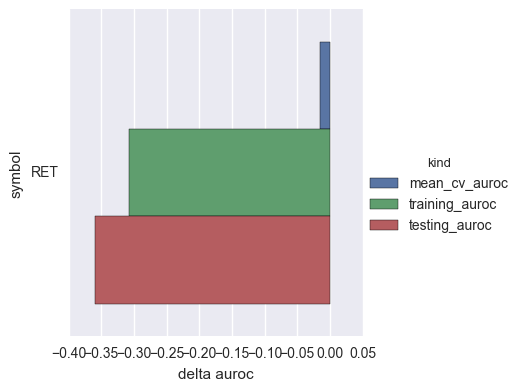

In [36]:
plot_df = pd.melt(auroc_dfs['diff_models_ab'], id_vars='symbol', value_vars=['mean_cv_auroc', 'training_auroc', 'testing_auroc'], var_name='kind', value_name='delta auroc')
grid = sns.factorplot(y='symbol', x='delta auroc', hue='kind', data=plot_df, kind="bar")